# Robust Ways of Preventing Overfitting
Currently, we restrain the depth of the random forest to 4 to prevent overfitting. In this notebook, we will explore potentially better ways of doing this. Specifically, we ask how important is depth (can we extend to 8 and still have reasonable results if slower convergence?). Are there other hyper parameters we can tune for a good random forest estimate?

# Importing important code
TODO: I really need to start putting code into a library :(

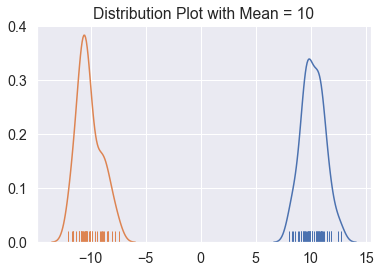

In [2]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 10, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

In [25]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators=200, max_samples=.63, bootstrap = True, 
                                depth=4, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_impurity_split=1e-7,
                                min_impurity_decrease=0,
                                splitter="best"):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, 
                                                     min_samples_split = min_samples_split, 
                                                     min_samples_leaf = min_samples_leaf, 
                                                     min_impurity_split = min_impurity_split,
                                                     min_impurity_decrease = min_impurity_decrease,
                                                     splitter = splitter), 
                              n_estimators =n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .63)


0.6912766091436614

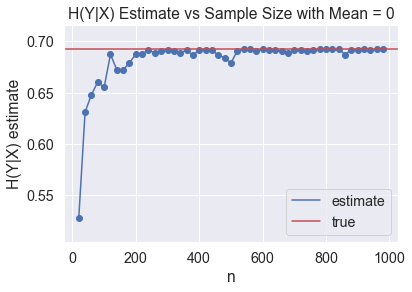

In [27]:
def get_cond_entropy_vs_n(mean, step = 20, depth = 4, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_impurity_split=1e-7,
                                min_impurity_decrease=0,
                                splitter = "best"):
    conditional_entropy = []
    sample_sizes = [i*step for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .63, 
                                                               depth = depth,
                                                               min_samples_split=min_samples_split, 
                                                               min_samples_leaf=min_samples_leaf, 
                                                               min_impurity_split=min_impurity_split,
                                                               min_impurity_decrease=min_impurity_decrease,
                                                               splitter=splitter))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

# Experiments:

## Experiment 1: Changing depth to 8

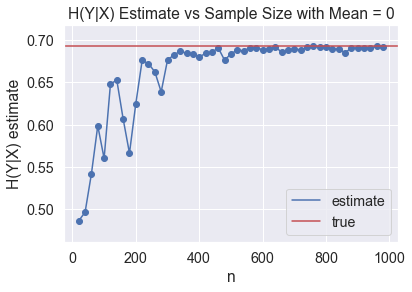

In [14]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, depth = 8)

plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

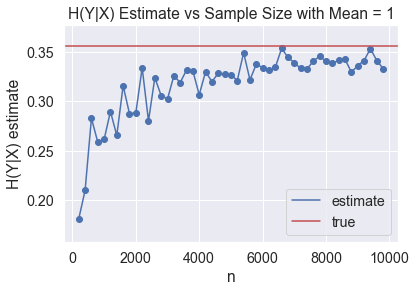

In [18]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, step = 200, depth = 8)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

## Preliminary Conclusion:
This seems to show that it takes longer to converge like we expect. However, we still get convergence which is good.

## Experiment 2: Changing other parameters: min_samples_leaf

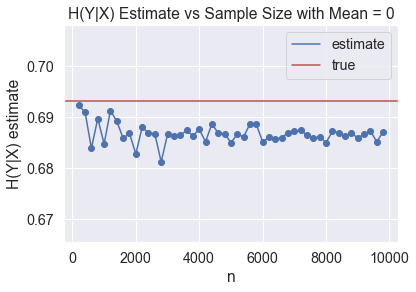

In [36]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, step = 200, depth = None, min_samples_leaf = 50)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

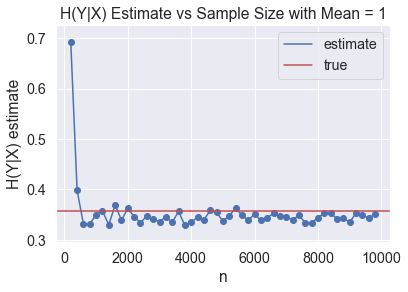

In [38]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, step = 200, depth = None, min_samples_leaf = 50)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

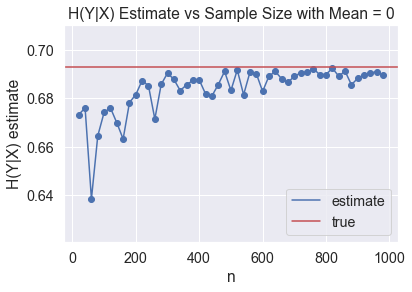

In [41]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, step = 20, depth = None, min_samples_leaf = .1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

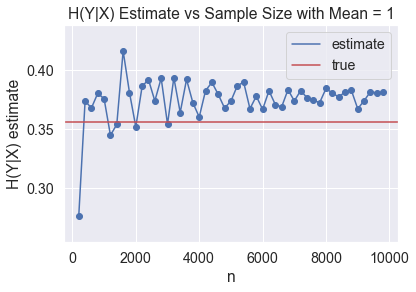

In [42]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, step = 200, depth = None, min_samples_leaf = .1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

You suffer a bad bias if low. But if you set to 50, you get pretty good results. One potential problem is that you need a lot of samples in this case.

## Choose Random for splitter

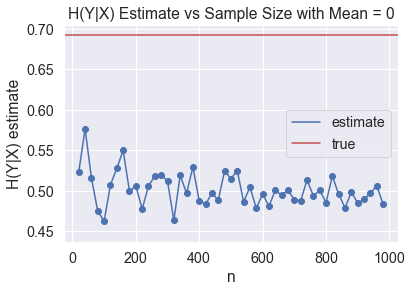

In [29]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, step = 20, depth = None, splitter = "random")
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

## Min impurity decrease

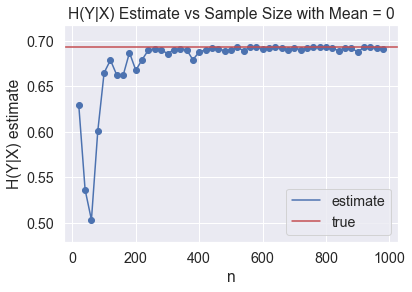

In [33]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, step = 20, depth = None, min_impurity_decrease=1e-2)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

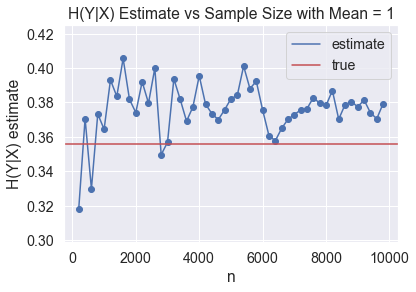

In [34]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, step = 200, depth = None, min_impurity_decrease=1e-2)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

## Experiment: min_samples_leaf to sqrt(n)

In [44]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators=200, max_samples=.63, bootstrap = True, 
                                depth=4, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_impurity_split=1e-7,
                                min_impurity_decrease=0,
                                splitter="best"):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, 
                                                     min_samples_split = min_samples_split, 
                                                     min_samples_leaf = int(math.sqrt(len(y))), 
                                                     min_impurity_split = min_impurity_split,
                                                     min_impurity_decrease = min_impurity_decrease,
                                                     splitter = splitter), 
                              n_estimators =n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .63)


0.6892941418372707

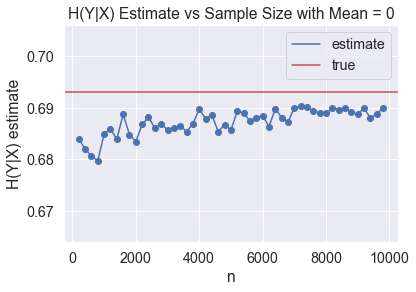

In [45]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, step = 200, depth = None)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

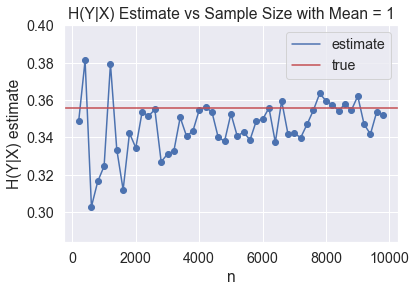

In [46]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, step = 200, depth = None)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

## Weighted Impurity Decrease Equation?